## This file prepares and does the EFM decomposition analysis
1. Model preparation 
    Glucose: (iLC915, iMT1026v3, iYli21, iYali4, iYLI647)
    RXN_ids: ['r1145', 'Ex_glc_D', 'R1440', '2189', 'EX_glc(e)']
2. Loading the EFM decomposition
3. Analysising the decomposition (which pathways are involved)


In [1]:
# imports
import cobra
import numpy as np # load efm data
import os
import sys # append path
from cobra.flux_analysis import pfba # parsimonious FBA

sys.path.append('../scripts/')
import helperFunction as hf
### If you want to reload the hf without closing the file or vs code: 
# from importlib import reload
# reload(hf)

config = hf.load_config()

models = hf.get_models()

_model_names = ['iLC915', 'iMT1026v3', 'iYli21', 'iYali4_corr', 'yli647_corr']
_glu_rxn_ids = ['r1145', 'Ex_glc_D', 'R1070', '1714', 'EX_glc(e)']
_maintenance_ids = ['-', '-', 'xMAINTENANCE', 'xMAINTENANCE', 'ATPM']

decomposing_models = {key: models[key] for key in _model_names}

_verbose = False # for additional print statements (e.g. important reactions from iLC915)
_ppa_maintenance = 2.81
_yli_maintenance = 7.86

In [11]:
decomposing_models

{'iLC915': '../data/models/Pichia_pastoris/iLC915/Ppa_iLC915_MODEL1507180065.xml',
 'iMT1026v3': '../data/models/Pichia_pastoris/iMT1026/Ppa_iMT1026v3_v2_read_write.xml',
 'iYli21': '../data/models/Yarrowia_lipolytica/iYli21/iYli21_v2.xml',
 'iYali4_corr': '../data/models/Yarrowia_lipolytica/iYali4/iYali4_corr_v2.xml',
 'yli647_corr': '../data/models/Yarrowia_lipolytica/iYLI647/iYLI647_corr_corr.xml'}

### Model preparation

In [24]:
_outdir = config['results']['EFM_model_dir']
_carbon_uptake = 2.43 # mmol/gDW/h

if not os.path.exists(_outdir):
    os.makedirs(_outdir)

#### iLC915: make everything for this model by hand

In [15]:
# load model
iLC915_model = cobra.io.read_sbml_model(decomposing_models['iLC915'])

In [48]:
# prepares iLC915 if _verbose = True: it presents the coefficients of the most important reactions
print('iLC915 model: ')

# prepare iLC915_model: needed because of internal cycles and active reactions
# lower and upper bounds of several reactions should be set to zero according to supplementary material of 
constraints_2_zero = ['r66','r910','r1104','r239','r111','r106','r490','r791','r243','r252','r253','r307','r308','r404','r405','r1320','r639','r640','r641','r642','r649','r650','r651','r652','r645','r646','r643','r644','r653','r654','r655','r656','r534'] 
for rxn_id in constraints_2_zero:
    rxn = iLC915_model.reactions.get_by_id(rxn_id)
    rxn.bounds = (0,0)
# constraint formulate uptake because of not meaningful results
formulate_uptake = iLC915_model.reactions.get_by_id('r1143')
formulate_uptake.bounds = (0,0)
# important carbon sources (biotin, CO2, urea)
important_carbon = ['r1132','r1137','r1177']

# all carbon containing exchange reactions
carbon_exchange_rxns = ['r1122', 'r1123', 'r1124', 'r1126', 'r1127', 'r1129', 'r1130', 'r1131', 'r1132', 'r1134', 'r1135', 'r1137', 'r1138', 'r1139', 'r1140', 'r1141', 'r1144', 'r1145', 'r1146', 'r1147', 'r1148', 'r1149', 'r1151', 'r1152', 'r1153', 'r1154', 'r1155', 'r1156', 'r1157', 'r1158', 'r1161', 'r1162', 'r1163', 'r1165', 'r1167', 'r1168', 'r1170', 'r1172', 'r1173', 'r1174', 'r1175', 'r1176', 'r1177', 'r1178']

# set all carbon exchange reactions to 0 except important ones
for rxn_id in carbon_exchange_rxns:
    if rxn_id not in important_carbon:
        rxn = iLC915_model.reactions.get_by_id(rxn_id)
        rxn.bounds = (0,0)

# check definition of important rxns 
important_rxns = ['r1133', 'r1141', 'r1145', 'r1144', 'r1148', 'r1160', 'r1137', 'r1188']

if _verbose: 
    for rxn_id in important_rxns:
        rxn = iLC915_model.reactions.get_by_id(rxn_id)
        print(rxn.reactants, rxn.products, rxn.bounds)
        print(rxn_id, rxn.name, hf.formulaWithNames(rxn), 'rxn coefficient: ', rxn.get_coefficient(list(rxn.metabolites.keys())[0]))



iLC915 model: 


In [26]:
# set objective: 
iLC915_model.objective = 'r1339' # biomass

# set maintenance reaction
maintenance = 'r1188'
maintenance_rxn = iLC915_model.reactions.get_by_id(maintenance)
# maintenance_rxn.bounds = (_ppa_maintenance,_ppa_maintenance)
# maintenance_rxn.bounds = (1,1) # according to iLC915_model
maintenance_rxn.bounds = (1.2434,1.2434) # according to iLC915 (1.2434 * 2.26 = 2.81)

In [50]:
glu_rxn = iLC915_model.reactions.get_by_id('r1145')
glu_rxn.bounds = (-_carbon_uptake, _carbon_uptake)
iLC915_model.summary()
# # write model
# cobra.io.write_sbml_model(iLC915_model, _outdir + 'iLC915_' + str(_carbon_uptake) + '_glucose.xml')


Metabolite,Reaction,Flux,C-Number,C-Flux
m2,r1145,2.43,0,0.00%
m1231,r1159,1.402,0,0.00%
m1232,r1160,3.52,0,0.00%
m1233,r1169,0.007449,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
m1226,r1133,-0.2432,0,0.00%
m1244,r1137,-4.624,0,0.00%
m30,r1150,-8.828,0,0.00%


#### iMT1026v3: reset carbon sources

In [77]:
# iMT1026v3: reset carbon sources to glucose
iMT1026v3_model = cobra.io.read_sbml_model(decomposing_models['iMT1026v3'])

# ATPM: check maintenance
atpm = iMT1026v3_model.reactions.get_by_id('ATPM')
atpm.lower_bound = _ppa_maintenance

# remove glyc reaction as carbon source
glyc_rxn = iMT1026v3_model.reactions.get_by_id('Ex_glyc')
glyc_rxn.bounds = (0, 1000)

# set glucose as carbon source
glu_rxn = iMT1026v3_model.reactions.get_by_id('Ex_glc_D')
glu_rxn.bounds = (-_carbon_uptake, _carbon_uptake)

# write model 
cobra.io.write_sbml_model(iMT1026v3_model, _outdir + 'iMT1026v3_' + str(_carbon_uptake) + '_glucose.xml')


In [ ]:
# Yli models: same direction and only glucose as growth substrate

In [79]:
_model_names

['iLC915', 'iMT1026v3', 'iYli21', 'iYali4_corr', 'yli647_corr']

In [9]:
# model_name = 'yli647_corr'
# carbon_rxn_id = 'EX_glc(e)'

yli_models = {'iYli21': 2, 'iYali4_corr': 3, 'yli647_corr': 4}
for model_name, idx in yli_models.items():
    print(model_name)
    model = cobra.io.read_sbml_model(decomposing_models[model_name])
    glu_rxn = model.reactions.get_by_id(_glu_rxn_ids[idx])
    print(glu_rxn.reaction)
    # print(model.summary()) # is glucose the only carbon source? yes
    # set maintenance reaction
    maintenance = model.reactions.get_by_id(_maintenance_ids[idx])
    maintenance.bounds = (_yli_maintenance, _yli_maintenance)
    
    # set uptake rate 2.43 mmol/gDW/h
    glu_rxn.bounds = (-_carbon_uptake, -_carbon_uptake)
    print(model.summary())

    # write model to sbml
    output_path = _outdir + model_name + '_' + str(_carbon_uptake) + '_glucose.xml'
    cobra.io.write_sbml_model(model, f'./{output_path}')



iYli21
m511[e] <=> 
Objective
1.0 biomass_C = 0.2827203777201979

Uptake
------
Metabolite Reaction    Flux  C-Number C-Flux
  m1031[e]    R1016   1.911         0  0.00%
   m511[e]    R1070    2.43         0  0.00%
   m342[e]    R1164   3.873         0  0.00%
  m1339[e]    R1287   5.056         0  0.00%
   m215[e]    R1296 0.01286         0  0.00%
  m1113[e]    R1333 0.01919         0  0.00%

Secretion
---------
Metabolite Reaction    Flux  C-Number C-Flux
  m1176[e]    R1030  -5.041         0  0.00%
   m214[e]    R1364  -16.62         0  0.00%
  m1401[c]    R1373 -0.2827         0  0.00%

iYali4_corr
m511 <=> 
Objective
1.0 biomass_C = 0.28193290167748836

Uptake
------
Metabolite Reaction    Flux  C-Number  C-Flux
     m1031     1654   1.905         0   0.00%
      m511     1714    2.43         6 100.00%
      m342     1832    4.12         0   0.00%
     m1339     1992   5.068         0   0.00%
      m215     2005 0.07434         0   0.00%
     m1113     2060 0.01913         0   0.00

In [ ]:
# investigate iYali4_corr
# 1714, 2189
iYali4_corr_model = cobra.io.read_sbml_model(decomposing_models['iYali4_corr'])
# r1714 = iYali4_corr_model.reactions.get_by_id('1714')
# r1714 # glucose
r2189 = iYali4_corr_model.reactions.get_by_id('2189')
r2189 # oleate

Reaction identifier,2189
Name,oleate exchange
Memory address,0x2affda0a0
Stoichiometry,m1463 --> oleate[ex] -->
GPR,
Lower bound,0.0
Upper bound,0.0


### Read the decomposition

"coefs" enthält die Koeffizienten
der Deomposition der FBA Lösung, 
"efms" enthält die 8 EFMs für die
decomposition und 
"optimal vector" ist die FBA Lösung, die ich für das
Modell bekommen habe.

In [3]:
# import cobra
import numpy as np # load efm data
import matplotlib.pyplot as plt
# import sys

In [4]:
coefs = np.load('../results/EFM_decomposition/coefs.npy')
efms = np.load('../results/EFM_decomposition/efms.npy')
optimal_vector = np.load('../results/EFM_decomposition/optimal_vector.npy')


##### Check the elements

In [5]:
# testing the loading
all(np.round(np.dot(efms.T,coefs),6) == np.round(optimal_vector,6))


True

In [6]:
coefs

array([1.85431378e-04, 1.78532090e-06, 4.22325033e-06, 7.95256645e-06,
       3.67321038e+00, 7.50199021e-01, 1.13669520e-01, 9.80653200e-03])

In [11]:
efms

array([[18192.81714286, 12187.01710801,  8664.24759582, ...,
            0.        ,  1219.51219512,     0.        ],
       [18192.81714286, 12187.01710801,  8664.24759582, ...,
            0.        ,  1219.51219512,     0.        ],
       [18192.81714286, 12187.01710801,  8664.24759582, ...,
            0.        ,  1219.51219512,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ]])

In [99]:
# Ranges der einzelnen EFMs  (minimaler Flux value - maximaler Flux value)
def min_max_efm(idx):
    efm = efms[idx]
    coef = coefs[idx]
    return min(efm), max(efm)
# efm1 = efms[0]
# coef1 = coefs[0]
# minimum and maximum flux values of efm1
# min(efm1)*coef1, max(efm1)*coef1 #(-3.448844644598554, 8.467661337641877)

# efm2 = efms[1]
# coef2 = coefs[1]
# # minimum and maximum flux values of efm2
# min(efm2)*coef2, max(efm2)*coef2 # (-0.0436757261298455, 0.08277381366985687)
for i in range(8):
    print(f'efm {i+1}: {min_max_efm(i)}')

## With coef
# efm 1: (-3.448844644598554, 8.467661337641877)
# efm 2: (-0.0436757261298455, 0.08277381366985687)
# efm 3: (-0.08445152571058413, 0.1958048750483668)
# efm 4: (-0.1446795871781187, 0.35895195482797465)
# efm 5: (-3.6732103771140117, 3.6732103771140117)
# efm 6: (-0.750199021125507, 0.750199021125507)
# efm 7: (0.0, 0.11366952033864189)
# efm 8: (-0.009806532002405393, 0.009806532002405393)

## Without coef
# efm 1: (-18599.03475609761, 45664.66273519176)
# efm 2: (-24463.79588850174, 46363.54932055749)
# efm 3: (-19996.80792682927, 46363.54932055749)
# efm 4: (-18192.817142857144, 45136.61812717771)
# efm 5: (-1.0, 1.0)
# efm 6: (-1.0, 1.0)
# efm 7: (0.0, 1.0)
# efm 8: (-1.0, 1.0)

efm 1: (-18599.03475609761, 45664.66273519176)
efm 2: (-24463.79588850174, 46363.54932055749)
efm 3: (-19996.80792682927, 46363.54932055749)
efm 4: (-18192.817142857144, 45136.61812717771)
efm 5: (-1.0, 1.0)
efm 6: (-1.0, 1.0)
efm 7: (0.0, 1.0)
efm 8: (-1.0, 1.0)


### Vector scaling

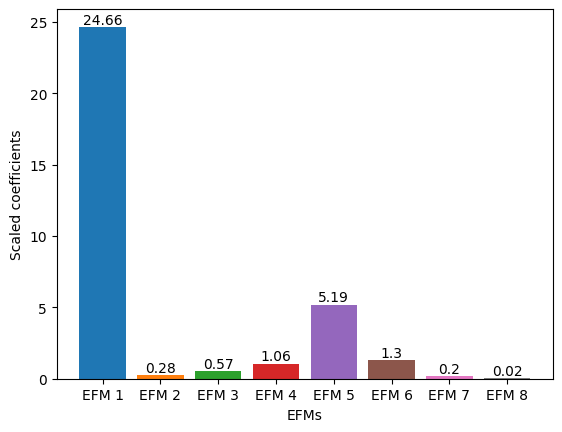

In [7]:
# scale efms and their coefficients to the same range
def scaled_efm(efm, coef):
    efm_scaled = efm/np.linalg.norm(efm)
    coef_scaled = coef * np.linalg.norm(efm)
    return efm_scaled, coef_scaled

scaled_efms = []
scaled_coefs = []
for i in range(8):
    efm_scaled, coef_scaled = scaled_efm(efms[i], coefs[i])
    scaled_efms.append(efm_scaled)
    scaled_coefs.append(coef_scaled)

# plot scaled coefficients as bar plot with x-axis = EFMs annotate values
_efm_names = [f'EFM {i}' for i in range(1, len(efms)+1)] 

plt.xlabel('EFMs')
plt.ylabel('Scaled coefficients')
for i in range(8):
    plt.bar(_efm_names[i], scaled_coefs[i])
    plt.annotate(round(scaled_coefs[i], 2), xy=(i, scaled_coefs[i]), ha='center', va='bottom')
plt.show()



In [60]:
optimal_vector

array([3.62751158, 2.43      , 1.72758612, ..., 0.        , 0.2431616 ,
       0.        ])

In [33]:
len(optimal_vector)

1423

#### Analyse the efms: Goal: which pathways are included in these efms? What are the differences?
Without groups:
1. Plot the decomposition parameters for the efms
2. Plot the number of active reactions per EFM
With groups: 
1. Combine Model reactions and efm solution (assume same order)
2. Take active reactions
3. get their group
4. Plot relative number of rxns in group

##### Without group (iLC915)

In [79]:
_efm_names = [f'EFM {i}' for i in range(1, len(efms)+1)] 
_efm_names

['EFM 1', 'EFM 2', 'EFM 3', 'EFM 4', 'EFM 5', 'EFM 6', 'EFM 7', 'EFM 8']

In [311]:
low_efms = list(range(0,4)) + [7]
np.ptp(coefs[low_efms])
coefs[low_efms]

array([1.85431378e-04, 1.78532090e-06, 4.22325033e-06, 7.95256645e-06,
       9.80653200e-03])

In [307]:
pow(10, -3.9)

0.00012589254117941674

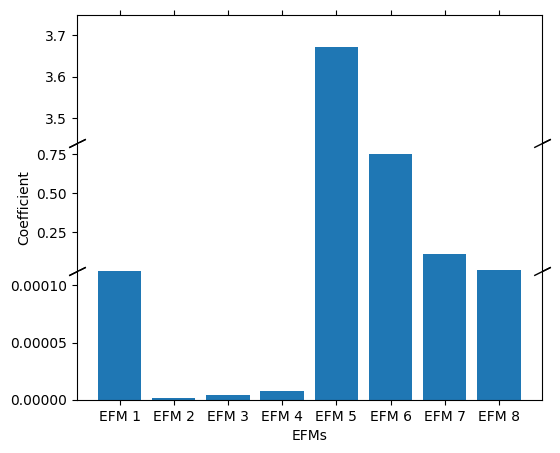

In [333]:
# plot coefficients of EFMs
# inspired by # Source: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(6, 5))
fig.subplots_adjust(hspace=0.000002)  # adjust space between axes

# same data on both axes
ax1.bar(_efm_names, coefs)
ax2.bar(_efm_names, coefs)
ax3.bar(_efm_names, coefs)

# EFM 1-4
first_end = pow(10, -3.95)
second_start = pow(10, -2.9)
second_end = 0.82
third_end = 3.75

# set value ranges
ax1.set_ylim(3.44, third_end)  # outliers only
ax2.set_ylim(second_start, second_end)  # most of the data
ax3.set_ylim(0, first_end)  # most of the data

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.spines.top.set_visible(False)
ax2.spines.bottom.set_visible(False)
ax2.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 
ax3.spines.top.set_visible(False)
ax3.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [0, 0], transform=ax2.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax3.plot([0, 1], [1, 1], transform=ax3.transAxes, **kwargs)

plt.xlabel('EFMs')
ax2.set_ylabel('Coefficient')
fig1 = plt.gcf()
plt.show()

outpath = '../results/EFM_decomposition/EFM_coefficients.png'
fig1.savefig(outpath) ()




In [9]:
_rxn_number = []
for efm in efms:
    _rxn_number.append(len(efm[np.where(efm!=0)]))
# [336, 342, 340, 340, 2, 3, 3, 3]


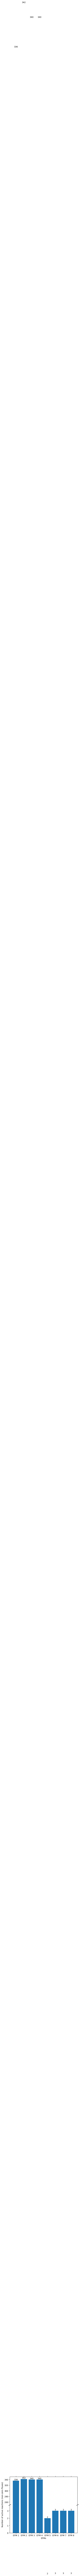

In [10]:
# plot number of active reactions (!=0) in each EFM

# inspired by # Source: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 5))
fig.subplots_adjust(hspace=0)  # adjust space between axes

# same data on both axes
ax1.bar(_efm_names, _rxn_number)
ax2.bar(_efm_names, _rxn_number)

# EFM 1-4
first_end = 3.8
second_start = 250
second_end = 350

# set value ranges
ax1.set_ylim(second_start, second_end) # upper half
ax2.set_ylim(0, first_end)  # lower half

ax1.spines.bottom.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
ax2.spines.top.set_visible(False)
ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

# # Add the values to the bars
for i, v in enumerate(_rxn_number):
    ax1.text(i, v, str(v), ha='center', va='bottom')
    ax2.text(i, v, str(v), ha='center', va='bottom')

# Add y-axis label for the whole figure
fig.text(0.03, 0.5, 'Number of active reactions (non-zero fluxes)', va='center', rotation='vertical')
plt.xlabel('EFMs')

fig1 = plt.gcf()
plt.show()

outpath = '../results/EFM_decomposition/active_reactions.png'
fig1.savefig(outpath)

In [359]:
plt.gcf()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [111]:
# # verify results: check if efm5 only contains two non-zero reactions
# efm5 = efms[4]
# efm5 # yes, it is true
# efm6 = efms[5]
# efm6 # yes, it is true
# efm7 = efms[6]
# efm7 # yes, it is true (7: 10; 18: 11,12)
# efm8 = efms[7]
# efm8 # yes, it is true

Combine EFMs and reaction ids

In [16]:
_rxm_ids = [rxn.id for rxn in iLC915_model.reactions]

In [17]:
# function which returns list of reactions with given indices
def get_rxns_from_indices(rxn_ids, indices):
    rxns = []
    for i in indices:
        rxns.append(rxn_ids[i])
    return rxns

In [20]:
# get active reactions and indices from EFMs
_efm_active_rxns = []
_efm_active_index = []

for efm in efms:
    non_zero_tuple = np.where(efm!=0)
    active_rxns = get_rxns_from_indices(_rxm_ids, non_zero_tuple[0])
    print(active_rxns)
    _efm_active_index.append(non_zero_tuple[0])
    _efm_active_rxns.append(active_rxns)

['r146', 'r552', 'r557', 'r576', 'r596', 'r872', 'r891', 'r978', 'r984', 'r988', 'r317', 'r318', 'r319', 'r623', 'r974', 'r982', 'r989', 'r63', 'r68', 'r70', 'r172', 'r173', 'r276', 'r403', 'r420', 'r909', 'r918', 'r1049', 'r878', 'r170', 'r171', 'r321', 'r333', 'r423', 'r424', 'r426', 'r849', 'r1081', 'r94', 'r227', 'r228', 'r270', 'r284', 'r842', 'r843', 'r237', 'r478', 'r518', 'r961', 'r1050', 'r1065', 'r1072', 'r1073', 'r163', 'r164', 'r249', 'r254', 'r316', 'r384', 'r524', 'r595', 'r599', 'r1083', 'r1084', 'r45', 'r145', 'r291', 'r511', 'r597', 'r775', 'r915', 'r964', 'r968', 'r86', 'r535', 'r575', 'r714', 'r876', 'r911', 'r953', 'r39', 'r40', 'r466', 'r479', 'r540', 'r708', 'r810', 'r831', 'r908', 'r979', 'r84', 'r85', 'r158', 'r159', 'r160', 'r247', 'r264', 'r530', 'r925', 'r926', 'r59', 'r174', 'r233', 'r904', 'r41', 'r181', 'r480', 'r499', 'r510', 'r522', 'r523', 'r585', 'r863', 'r879', 'r889', 'r928', 'r955', 'r956', 'r981', 'r996', 'r100', 'r795', 'r846', 'r77', 'r78', 'r81'

In [67]:
_efm_active_rxns[0].index('r1145')
efm[rxn_idx[efm_rxns.index('r1339')]]

# optimal oxygen value: 
optimal_vector[rxn_idx[efm_rxns.index(biomass_rxn_id)]]

0.24316160450778912

In [93]:
import pandas as pd
glucose_rxn_id = 'r1145'
oxygen_rxn_id = 'r1160'
biomass_rxn_id = 'r1339'
glucose_uptake = 2.43 # mmol/gDW/h # optimal_vector[rxn_idx[efm_rxns.index(glucose_rxn_id)]]
oxygen_uptake = 3.52 # mmol/gDW/h # optimal_vector[rxn_idx[efm_rxns.index(oxygen_rxn_id)]]
biomass_production = 0.2432 # gDW/h # optimal_vector[rxn_idx[efm_rxns.index(biomass_rxn_id)]]
glucose_results = [round(efms[i][rxn_idx[efm_rxns.index(glucose_rxn_id)]]*coefs[i]/glucose_uptake*100,1) for i in range(len(efms))]
oxygen_results = [round(efms[i][rxn_idx[efm_rxns.index(oxygen_rxn_id)]]*coefs[i]/oxygen_uptake*100,1) for i in range(len(efms))]
biomass_results = [round(efms[i][rxn_idx[efm_rxns.index(biomass_rxn_id)]]*coefs[i]/biomass_production*100,1) for i in range(len(efms))]
efm_names = [f'EFM {i}' for i in range(1, len(efms)+1)]
# dataframe of efm names, glucose, oxygen, biomass
efm_results = pd.DataFrame(list(zip(efm_names, glucose_results, oxygen_results, biomass_results)), columns=['EFM', 'glucose uptake', 'oxygen uptake', 'biomass production'])

In [94]:
efm_results.to_csv('../results/EFM_decomposition/efm_iLC915_proportion.csv', index=False)

# efm_rasdf = efm_results.round(1)
efm_results

,EFM,glucose uptake,oxygen uptake,biomass production
0,EFM 1,93.0,93.0,93.0
1,EFM 2,0.9,0.9,0.9
2,EFM 3,2.1,2.1,2.1
3,EFM 4,4.0,4.0,4.0
4,EFM 5,0.0,0.0,0.0
5,EFM 6,0.0,0.0,0.0
6,EFM 7,0.0,0.0,0.0
7,EFM 8,0.0,0.0,0.0


In [96]:
# investigate glucose and oxygen uptake and biomass production => Table
def efm_glu_oxy_bio(idx):
    coef = coefs[idx]
    efm = efms[idx]
    overall_glucose = 2.43 
    try:
        glucose = efm[rxn_idx[efm_rxns.index('r1145')]]
        oxygen = efm[rxn_idx[efm_rxns.index('r1160')]]
        biomass = efm[rxn_idx[efm_rxns.index('r1339')]]
    except:
        glucose = 0
        oxygen = 0
        biomass = 0
    return glucose*coef, oxygen*coef, biomass*coef

for i in range(8):
    print(f'efm {i}: {efm_glu_oxy_bio(i)}')

# # Glucose, Oxygen, Biomass
# # With coef
# efm 0: (2.2598553762487645, 3.273942178139574, 0.22613582684929817)
# efm 1: (0.021757736369912017, 0.03152129625239124, 0.002177220611589034)
# efm 2: (0.051468824044256414, 0.07456492821122293, 0.005150305282601301)
# efm 3: (0.09691806333646344, 0.14040904507241417, 0.009698251764059447)

# # Without coef
# efm 0: (12187.017108013935, 17655.815391986063, 1219.5121951219512)
# efm 1: (12187.017108013935, 17655.815391986063, 1219.5121951219512)
# efm 2: (12187.017108013937, 17655.815391986063, 1219.5121951219512)
# efm 3: (12187.017108013937, 17655.815391986063, 1219.5121951219512)


efm 0: (2.2598553762487645, 3.273942178139574, 0.22613582684929817)
efm 1: (0.021757736369912017, 0.03152129625239124, 0.002177220611589034)
efm 2: (0.051468824044256414, 0.07456492821122293, 0.005150305282601301)
efm 3: (0.09691806333646344, 0.14040904507241417, 0.009698251764059447)
efm 4: (0.0, 0.0, 0.0)
efm 5: (0.0, 0.0, 0.0)
efm 6: (0.0, 0.0, 0.0)
efm 7: (0.0, 0.0, 0.0)


Check Rxns (get name, formula with metabolites and investigate possible pathway)

In [375]:
iLC915_model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
m2,r1145,2.43,0,0.00%
m1231,r1159,1.402,0,0.00%
m1232,r1160,3.52,0,0.00%
m1233,r1169,0.007449,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
m1226,r1133,-0.2432,0,0.00%
m1244,r1137,-4.624,0,0.00%
m30,r1150,-8.828,0,0.00%


EFM 1: 336 reactions: includes uptake: 12187 * 0,0001854313 = 2.25985; biomass reaction 1219.512195 * 0,0001854313 = 0.226136;
Glycolysis 
enolase(iMT1026v3) 2-phospho-D-glycerate hydro-lyase (phosphoenolpyruvate-forming)(iMT1026v3): positive flux => Glycolysis is on
Phosphoglycerate mutase(iMT1026v3), 2-Phospho-D-glycerate 2,3-phosphomutase(iLC915): negative flux => 3-Phosphoglycerate to 2-Phosphoglycerate => Glycolysis is on
Pyruvate oxidation: 
pyruvate:thiamin diphosphate acetaldehydetransferase: positive flux + acetyl-CoA:enzyme N6-(dihydrolipoyl)lysine S-acetyltransferase: positive flux -> Acetyl-CoA is produced 
found different definition of the chemical formula of 2-(alpha-Hydroxyethyl)thiamine diphosphate
TCA: Activity
citrate hydroxymutase: citrate <-> isocitrate: positive flux: -> TCA active
Succinate:CoA ligase (GDP-forming): succinate + GTP <-> succinyl-CoA + GDP: negative flux so succinyl-CoA -> succinate -> TCA Active
(S)-malate:NAD+ oxidoreductase: Malate <=> Oxaloacetate: positive flux -> TCA Active

In [163]:
# print rnx name and formula with metabolite names
efm_rxns = _efm_active_rxns[0]
rxn_idx = _efm_active_index[0]
efm = efms[0]
for idx in range(len(efm_rxns)):
    rxn = iLC915_model.reactions.get_by_id(efm_rxns[idx])
    print(rxn.id, rxn.name, hf.formulaWithNames(rxn), efm[rxn_idx[idx]])
    

r146 D-glyceraldehyde-3-phosphate:NAD+ oxidoreductase (phosphorylating) D-Glyceraldehyde 3-phosphate_C3H7O6P + NAD+_C21H28N7O14P2 + Orthophosphate_H3PO4 <=> 3-Phospho-D-glyceroyl phosphate_C3H8O10P2 + NADH_C21H29N7O14P2 + H+_H 18192.817142857144
r552 ATP:alpha-D-glucose 6-phosphotransferase ATP_C10H16N5O13P3 + alpha-D-Glucose_C6H12O6 --> ADP_C10H15N5O10P2 + alpha-D-Glucose 6-phosphate_C6H13O9P 12187.017108013935
r557 ATP:D-fructose-6-phosphate 1-phosphotransferase ATP_C10H16N5O13P3 + beta-D-Fructose 6-phosphate_C6H13O9P --> ATP_C10H16N5O13P30 + ADP_C10H15N5O10P2 8664.247595818815
r576 ATP:pyruvate 2-O-phosphotransferase Phosphoenolpyruvate_C3H5O6P + ADP_C10H15N5O10P2 --> ATP_C10H16N5O13P3 + Pyruvate_C3H4O3 15269.562386759584
r596 ATP:3-phospho-D-glycerate 1-phosphotransferase ATP_C10H16N5O13P3 + ATP_C10H16N5O13P37 <=> ATP_C10H16N5O13P34 + ADP_C10H15N5O10P2 -18192.817142857144
r872 beta-D-fructose-1,6-bisphosphate D-glyceraldehyde-3-phosphate-lyase beta-D-Fructose 1,6-bisphosphate_C6H14

EFM 2: 
biomass occuring: 1219,512195 * 0,0000078532 = 0,009577
glucose uptake: 12187,017108 * 0,0000078532 = 0.095707
Glycolysis 
enolase(iMT1026v3) 2-phospho-D-glycerate hydro-lyase (phosphoenolpyruvate-forming)(iMT1026v3): positive flux => Glycolysis is on
Phosphoglycerate mutase(iMT1026v3), 2-Phospho-D-glycerate 2,3-phosphomutase(iLC915): negative flux => 3-Phosphoglycerate to 2-Phosphoglycerate => Glycolysis is on
Pyruvate oxidation: 
pyruvate:thiamin diphosphate acetaldehydetransferase: positive flux + acetyl-CoA:enzyme N6-(dihydrolipoyl)lysine S-acetyltransferase: positive flux -> Acetyl-CoA is produced 
found different definition of the chemical formula of 2-(alpha-Hydroxyethyl)thiamine diphosphate
TCA: Activity
citrate hydroxymutase: citrate <-> isocitrate: positive flux: -> TCA active
Succinate:CoA ligase (GDP-forming): succinate + GTP <-> succinyl-CoA + GDP: negative flux so succinyl-CoA -> succinate -> TCA Active
(S)-malate:NAD+ oxidoreductase: Malate <=> Oxaloacetate: positive flux -> TCA Active

In [167]:
# print rnx name and formula with metabolite names
efm_rxns = _efm_active_rxns[1]
rxn_idx = _efm_active_index[1]
efm = efms[1]
for idx in range(len(efm_rxns)):
    rxn = iLC915_model.reactions.get_by_id(efm_rxns[idx])
    print(rxn.id, rxn.name, hf.formulaWithNames(rxn), efm[rxn_idx[idx]])

r146 D-glyceraldehyde-3-phosphate:NAD+ oxidoreductase (phosphorylating) D-Glyceraldehyde 3-phosphate_C3H7O6P + NAD+_C21H28N7O14P2 + Orthophosphate_H3PO4 <=> 3-Phospho-D-glyceroyl phosphate_C3H8O10P2 + NADH_C21H29N7O14P2 + H+_H 18192.81714285714
r552 ATP:alpha-D-glucose 6-phosphotransferase ATP_C10H16N5O13P3 + alpha-D-Glucose_C6H12O6 --> ADP_C10H15N5O10P2 + alpha-D-Glucose 6-phosphate_C6H13O9P 12187.017108013935
r557 ATP:D-fructose-6-phosphate 1-phosphotransferase ATP_C10H16N5O13P3 + beta-D-Fructose 6-phosphate_C6H13O9P --> ATP_C10H16N5O13P30 + ADP_C10H15N5O10P2 8664.247595818815
r576 ATP:pyruvate 2-O-phosphotransferase Phosphoenolpyruvate_C3H5O6P + ADP_C10H15N5O10P2 --> ATP_C10H16N5O13P3 + Pyruvate_C3H4O3 15269.562386759582
r596 ATP:3-phospho-D-glycerate 1-phosphotransferase ATP_C10H16N5O13P3 + ATP_C10H16N5O13P37 <=> ATP_C10H16N5O13P34 + ADP_C10H15N5O10P2 -18192.81714285714
r872 beta-D-fructose-1,6-bisphosphate D-glyceraldehyde-3-phosphate-lyase beta-D-Fructose 1,6-bisphosphate_C6H14O1

In [152]:
coefs[0] # 0.0000078532

0.0001854313780164245

EFM 3: 
biomass formation: 1219,512195 * 0,00000422325 = 0,00515
glucose uptake: 12187,017108 * 0,00000422325 = 0.051468
Glycolysis 
enolase(iMT1026v3) 2-phospho-D-glycerate hydro-lyase (phosphoenolpyruvate-forming)(iMT1026v3): positive flux => Glycolysis is on
Phosphoglycerate mutase(iMT1026v3), 2-Phospho-D-glycerate 2,3-phosphomutase(iLC915): negative flux => 3-Phosphoglycerate to 2-Phosphoglycerate => Glycolysis is on
Pyruvate oxidation: 
pyruvate:thiamin diphosphate acetaldehydetransferase: positive flux + acetyl-CoA:enzyme N6-(dihydrolipoyl)lysine S-acetyltransferase: positive flux -> Acetyl-CoA is produced 
found different definition of the chemical formula of 2-(alpha-Hydroxyethyl)thiamine diphosphate
TCA: Activity
citrate hydroxymutase: citrate <-> isocitrate: positive flux: -> TCA active
Succinate:CoA ligase (GDP-forming): succinate + GTP <-> succinyl-CoA + GDP: negative flux so succinyl-CoA -> succinate -> TCA Active
(S)-malate:NAD+ oxidoreductase: Malate <=> Oxaloacetate: positive flux -> TCA Active

In [165]:
coefs[2] # 0.00000422325


4.2232503317330666e-06

In [168]:
# print rnx name and formula with metabolite names
efm_rxns = _efm_active_rxns[2]
rxn_idx = _efm_active_index[2]
efm = efms[2]
for idx in range(len(efm_rxns)):
    rxn = iLC915_model.reactions.get_by_id(efm_rxns[idx])
    print(rxn.id, rxn.name, hf.formulaWithNames(rxn), efm[rxn_idx[idx]])

r146 D-glyceraldehyde-3-phosphate:NAD+ oxidoreductase (phosphorylating) D-Glyceraldehyde 3-phosphate_C3H7O6P + NAD+_C21H28N7O14P2 + Orthophosphate_H3PO4 <=> 3-Phospho-D-glyceroyl phosphate_C3H8O10P2 + NADH_C21H29N7O14P2 + H+_H 18192.817142857144
r552 ATP:alpha-D-glucose 6-phosphotransferase ATP_C10H16N5O13P3 + alpha-D-Glucose_C6H12O6 --> ADP_C10H15N5O10P2 + alpha-D-Glucose 6-phosphate_C6H13O9P 12187.017108013937
r557 ATP:D-fructose-6-phosphate 1-phosphotransferase ATP_C10H16N5O13P3 + beta-D-Fructose 6-phosphate_C6H13O9P --> ATP_C10H16N5O13P30 + ADP_C10H15N5O10P2 8664.247595818817
r576 ATP:pyruvate 2-O-phosphotransferase Phosphoenolpyruvate_C3H5O6P + ADP_C10H15N5O10P2 --> ATP_C10H16N5O13P3 + Pyruvate_C3H4O3 15269.562386759584
r596 ATP:3-phospho-D-glycerate 1-phosphotransferase ATP_C10H16N5O13P3 + ATP_C10H16N5O13P37 <=> ATP_C10H16N5O13P34 + ADP_C10H15N5O10P2 -18192.817142857144
r872 beta-D-fructose-1,6-bisphosphate D-glyceraldehyde-3-phosphate-lyase beta-D-Fructose 1,6-bisphosphate_C6H14

EFM 4: 

biomass formation: 1219,512195 * 0,000007952566 = 0,009698
glucose uptake: 12187,017108 * 0,000007952566 = 0.096918
Glycolysis 
enolase(iMT1026v3) 2-phospho-D-glycerate hydro-lyase (phosphoenolpyruvate-forming)(iMT1026v3): positive flux => Glycolysis is on
Phosphoglycerate mutase(iMT1026v3), 2-Phospho-D-glycerate 2,3-phosphomutase(iLC915): negative flux => 3-Phosphoglycerate to 2-Phosphoglycerate => Glycolysis is on
Pyruvate oxidation: 
pyruvate:thiamin diphosphate acetaldehydetransferase: positive flux + acetyl-CoA:enzyme N6-(dihydrolipoyl)lysine S-acetyltransferase: positive flux -> Acetyl-CoA is produced 
found different definition of the chemical formula of 2-(alpha-Hydroxyethyl)thiamine diphosphate
TCA: Activity
citrate hydroxymutase: citrate <-> isocitrate: positive flux: -> TCA active
Succinate:CoA ligase (GDP-forming): succinate + GTP <-> succinyl-CoA + GDP: negative flux so succinyl-CoA -> succinate -> TCA Active
(S)-malate:NAD+ oxidoreductase: Malate <=> Oxaloacetate: positive flux -> TCA Active

In [170]:
coefs[3] # 0.000007952566

7.952566446528747e-06

In [171]:
# print rnx name and formula with metabolite names
efm_rxns = _efm_active_rxns[3]
rxn_idx = _efm_active_index[3]
efm = efms[3]
for idx in range(len(efm_rxns)):
    rxn = iLC915_model.reactions.get_by_id(efm_rxns[idx])
    print(rxn.id, rxn.name, hf.formulaWithNames(rxn), efm[rxn_idx[idx]])

r146 D-glyceraldehyde-3-phosphate:NAD+ oxidoreductase (phosphorylating) D-Glyceraldehyde 3-phosphate_C3H7O6P + NAD+_C21H28N7O14P2 + Orthophosphate_H3PO4 <=> 3-Phospho-D-glyceroyl phosphate_C3H8O10P2 + NADH_C21H29N7O14P2 + H+_H 18192.817142857144
r552 ATP:alpha-D-glucose 6-phosphotransferase ATP_C10H16N5O13P3 + alpha-D-Glucose_C6H12O6 --> ADP_C10H15N5O10P2 + alpha-D-Glucose 6-phosphate_C6H13O9P 12187.017108013937
r557 ATP:D-fructose-6-phosphate 1-phosphotransferase ATP_C10H16N5O13P3 + beta-D-Fructose 6-phosphate_C6H13O9P --> ATP_C10H16N5O13P30 + ADP_C10H15N5O10P2 8664.247595818817
r576 ATP:pyruvate 2-O-phosphotransferase Phosphoenolpyruvate_C3H5O6P + ADP_C10H15N5O10P2 --> ATP_C10H16N5O13P3 + Pyruvate_C3H4O3 15269.562386759584
r596 ATP:3-phospho-D-glycerate 1-phosphotransferase ATP_C10H16N5O13P3 + ATP_C10H16N5O13P37 <=> ATP_C10H16N5O13P34 + ADP_C10H15N5O10P2 -18192.817142857144
r872 beta-D-fructose-1,6-bisphosphate D-glyceraldehyde-3-phosphate-lyase beta-D-Fructose 1,6-bisphosphate_C6H14

Check difference of EFMs 1-4 with Set operations

In [181]:
efm_rxns = _efm_active_rxns[1]
rxn_set_1 = set(_efm_active_rxns[0])
rxn_set_2 = set(_efm_active_rxns[1])
rxn_set_3 = set(_efm_active_rxns[2])
rxn_set_4 = set(_efm_active_rxns[3])
# len(rxn_set_1) # 336
# len(rxn_set_2) # 342
# len(rxn_set_3) # 340
# len(rxn_set_4) # 340

336

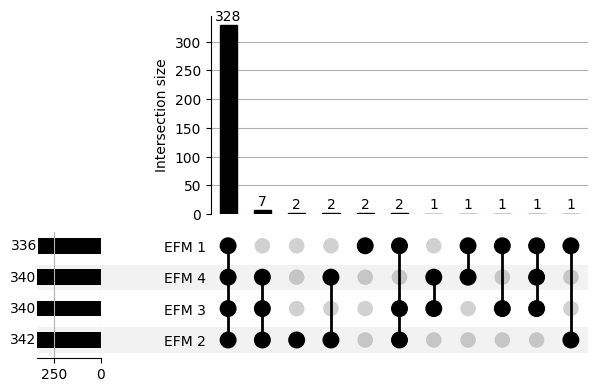

In [371]:
# plot 
import pandas as pd
from upsetplot import plot

set_names = ['EFM 1', 'EFM 2', 'EFM 3', 'EFM 4']
all_elems = rxn_set_1.union(rxn_set_2).union(rxn_set_3).union(rxn_set_4)
df = pd.DataFrame([[e in rxn_set_1, e in rxn_set_2, e in rxn_set_3, e in rxn_set_4] for e in all_elems], columns = set_names)
df_up = df.groupby(set_names).size()
plot(df_up, orientation='horizontal', sort_by='cardinality', show_counts=True)
fig1 = plt.gcf()
plt.show()

outpath = '../results/EFM_decomposition/upset_plot_EFM1-4.png'
fig1.savefig(outpath)

In [222]:
# only set 1 = all - set 2, set 3, set 4
only_set_1 = all_elems - rxn_set_2 - rxn_set_3 - rxn_set_4
only_set_1 # {'r1246', 'r537'}

# rxn_r1246 = iLC915_model.reactions.get_by_id('r1246')
# rxn_r1246 # H2O mitochondrial membrane diffusion
# hf.formulaWithNames(rxn_r1246) # 'H2O[mitochondrial membrane] <=> H2O[cytoplasm]'

# rxn_r537 = iLC915_model.reactions.get_by_id('r537')
# rxn_r537 # L-Valine:pyruvate aminotransferase
# hf.formulaWithNames(rxn_r537) # 'Pyruvate_C3H4O3 + L-Valine_C5H11NO2 <=> L-Alanine_C3H7NO2 + 3-Methyl-2-oxobutanoic acid_C5H8O3'

# # only set 2 = all - set 1, set 3, set 4
only_set_2 = all_elems - rxn_set_1 - rxn_set_3 - rxn_set_4
only_set_2 # {'r1190', 'r950'}

# rxn_r1190 = iLC915_model.reactions.get_by_id('r1190')
# rxn_r1190 # (R)-2,3-Dihydroxy-3-methylpentanoate mitochondrial transport

# rxn_r950 = iLC915_model.reactions.get_by_id('r950')
# rxn_r950 # (R)-2,3-Dihydroxy-3-methylpentanoate hydro-lyase


# only set 3 = all - set 2, set 4: {'r1246', 'r500', 'r537'}
# only_set_3 = all_elems - rxn_set_2 - rxn_set_4 # {'r1246', 'r500', 'r537'}
only_set_3 = all_elems - rxn_set_1 - rxn_set_4 # {'r1190', 'r950'}
# only_set_3 = all_elems - rxn_set_1 - rxn_set_2 - rxn_set_4 # set()
only_set_3

# rxn_r1246 = iLC915_model.reactions.get_by_id('r1246')
# rxn_r1246 # H2O mitochondrial membrane diffusion
# hf.formulaWithNames(rxn_r1246) # 'H2O[mitochondrial membrane] <=> H2O[cytoplasm]'

# rxn_r537 = iLC915_model.reactions.get_by_id('r537')
# rxn_r537 # L-Valine:pyruvate aminotransferase
# hf.formulaWithNames(rxn_r537) # 'Pyruvate_C3H4O3 + L-Valine_C5H11NO2 <=> L-Alanine_C3H7NO2 + 3-Methyl-2-oxobutanoic acid_C5H8O3'

# rxn_r500 = iLC915_model.reactions.get_by_id('r500')
# rxn_r500 # squalene synthase
# hf.formulaWithNames(rxn_r500) # 'H+_H + NADPH_C21H30N7O17P3 + 2.0 trans,trans-Farnesyl diphosphate_C15H28O7P2 <=> 2.0 Diphosphate_P2H4O7 + NADP+_C21H29N7O17P3 + Squalene_C30H50'

# # # only set 4 = all - set1, set 2, set 3
# only_set_4 = all_elems - rxn_set_2 - rxn_set_3 # {'r1246', 'r537', 'r71'}
# only_set_4 = all_elems - rxn_set_1 - rxn_set_2 - rxn_set_3 # set ()
only_set_4 = all_elems - rxn_set_1 - rxn_set_3 # {'r1190', 'r501', 'r502', 'r950'}
only_set_4

rxn_r501 = iLC915_model.reactions.get_by_id('r501')
rxn_r501 # Farnesyl-diphosphate:farnesyl-diphosphate farnesyltransferase
hf.formulaWithNames(rxn_r501) # '2.0 trans,trans-Farnesyl diphosphate_C15H28O7P2 --> Presqualene diphosphate_C30H52O7P2 + Diphosphate_P2H4O7'

# rxn_r502 = iLC915_model.reactions.get_by_id('r502')
# rxn_r502 # Presqualene diphosphate:farnesyl-diphosphate farnesyltransferase
hf.formulaWithNames(rxn_r502) # 'Presqualene diphosphate_C30H52O7P2 + H+_H + NADPH_C21H30N7O17P3 --> Diphosphate_P2H4O7 + NADP+_C21H29N7O17P3 + Squalene_C30H50'

# rxn_r71 = iLC915_model.reactions.get_by_id('r71')
# rxn_r71 # Isocitrate:NADP+ oxidoreductase (decarboxylating)
# hf.formulaWithNames(rxn_r71) # 'Isocitrate_C6H8O7 + NADP+_C21H29N7O17P3 --> 2-Oxoglutarate_C5H6O5 + H+_H + CO2_CO2 + NADPH_C21H30N7O17P3'



'Presqualene diphosphate_C30H52O7P2 + H+_H + NADPH_C21H30N7O17P3 --> Diphosphate_P2H4O7 + NADP+_C21H29N7O17P3 + Squalene_C30H50'

EFM 5: Water mitochondrial (transport of water through micochondial membrane)

In [372]:
# print rnx name and formula with metabolite names
efm_rxns = _efm_active_rxns[4]
rxn_idx = _efm_active_index[4]
efm = efms[4]
for idx in range(len(efm_rxns)):
    rxn = iLC915_model.reactions.get_by_id(efm_rxns[idx])
    print(rxn.id, rxn.name, hf.formulaWithNames(rxn), efm[rxn_idx[idx]])
# r1192 Water mitochondrial permease H2O_H2O <=> H2O_H2O
# r1246 H2O mitochondrial membrane diffusion H2O_H2O <=> H2O_H2O
r1192 = iLC915_model.reactions.get_by_id('r1192')
r1192

r1192 Water mitochondrial permease H2O_H2O <=> H2O_H2O 1.0
r1246 H2O mitochondrial membrane diffusion H2O_H2O <=> H2O_H2O -1.0


Reaction identifier,r1192
Name,Water mitochondrial permease
Memory address,0x2a06968b0
Stoichiometry,m80 <=> m5 H2O_H2O <=> H2O_H2O
GPR,
Lower bound,-1000.0
Upper bound,1000.0


EFM 6: Citrate/Isocitrate Shuttle: https://pubmed.ncbi.nlm.nih.gov/33499062/, https://www.jbc.org/article/S0021-9258(20)68110-8/pdf
Pyruvate is produced through Glycolysis in cytosol, 
in mitochondria: Pyruvate dehydrogenase complex: Pyruvate to Acetyl-CoA, 
Acetyl-CoA is required for Citrate cycle (also in the mitochondria)
CoA: synthesized in cytosol and transported into mitochondria using Mitochondrial CoA transporter (mitochondrial carrier family)
Physiology of this transport: according to chatgpt: its an antiport with H+ and can be used for the transport of acetly coa into the cell or out of the cell (Citrate-Malate shuttle is used actually)


In [373]:
# print rnx name and formula with metabolite names
efm_rxns = _efm_active_rxns[5]
rxn_idx = _efm_active_index[5]
efm = efms[5]
for idx in range(len(efm_rxns)):
    rxn = iLC915_model.reactions.get_by_id(efm_rxns[idx])
    print(rxn.id, rxn.name, hf.formulaWithNames(rxn), efm[rxn_idx[idx]])

# r918 citrate hydroxymutase Citrate_C6H8O7 <=> Isocitrate_C6H8O7 # (mitochondrial) citrate: M_m95 Isocitrate: M_m98
# r920 citrate hydroxymutase Citrate_C6H8O7 <=> Isocitrate_C6H8O7 # (cytosolic) citrate: M_m1202 Isocitrate: M_m100
# r1273 citrate/isocitrate mitochondrial shuttle Citrate_C6H8O7 + Isocitrate_C6H8O7 <=> Isocitrate_C6H8O7 + Citrate_C6H8O7 # (antiporter: cytosolic citrate + mitocontrial isocitrate ...) M_m1202 + M_m98 <=> M_m100 + M_m95 

# Why are there two citrate hydroxymutase reactions: Citrate <-> Isocitrate (mitochondrial) and Citrate <-> Isocitrate (cytosolic)
r1273 = iLC915_model.reactions.get_by_id('r1273')
r1273

r918 citrate hydroxymutase Citrate_C6H8O7 <=> Isocitrate_C6H8O7 -1.0
r920 citrate hydroxymutase Citrate_C6H8O7 <=> Isocitrate_C6H8O7 1.0
r1273 citrate/isocitrate mitochondrial shuttle Citrate_C6H8O7 + Isocitrate_C6H8O7 <=> Isocitrate_C6H8O7 + Citrate_C6H8O7 -1.0


Reaction identifier,r1273
Name,citrate/isocitrate mitochondrial shuttle
Memory address,0x2a2b0a790
Stoichiometry,m1202 + m98 <=> m100 + m95 Citrate_C6H8O7 + Isocitrate_C6H8O7 <=> Isocitrate_C6H8O7 + Citrate_C6H8O7
GPR,PAS_chr3_0177 or PAS_chr3_0769
Lower bound,-1000.0
Upper bound,1000.0


EFM 7: Aminoacid transformation: Its a selfdependent cycle
1. L_Glutamate + 3-Methyl-2-oxobutanoic acid <-> 2-Oxolgluterate + L-Valine 
2. 2-Oxoglutarate + L-Alanine <-> L-Glutamate + Pyruvate
3. Pyruvate + L-Valine <-> L-Alanine + 3-Methyl-2-oxobutanic acid

In [142]:
# print rnx name and formula with metabolite names
efm_rxns = _efm_active_rxns[6]
rxn_idx = _efm_active_index[6]
efm = efms[6]
for idx in range(len(efm_rxns)):
    rxn = iLC915_model.reactions.get_by_id(efm_rxns[idx])
    print(rxn.id, rxn.name, hf.formulaWithNames(rxn), efm[rxn_idx[idx]])

# r529 L-Alanine:2-oxoglutarate aminotransferase 2-Oxoglutarate_C5H6O5 + L-Alanine_C3H7NO2 <=> L-Glutamate_C5H9NO4 + Pyruvate_C3H4O3 1.0
# r532 L-Valine:2-oxoglutarate aminotransferase L-Glutamate_C5H9NO4 + 3-Methyl-2-oxobutanoic acid_C5H8O3 <=> 2-Oxoglutarate_C5H6O5 + L-Valine_C5H11NO2 1.0
# r537 L-Valine:pyruvate aminotransferase Pyruvate_C3H4O3 + L-Valine_C5H11NO2 <=> L-Alanine_C3H7NO2 + 3-Methyl-2-oxobutanoic acid_C5H8O3 1.0

# r529 (iLC915) <=> R_ALATA_L (iMT1026v3) (both cytosolic) SUBSYSTEM: Alanine and Aspartate Metabolism<
# r532 (iLC915) <=> R_VALTA (iMT1026v3) (both cytosolic) SUBSYSTEM: Valine, Leucine, and Isoleucine Metabolism
# r537 (iLC915) <=> R_VPAMT (iMT1026v3) (both cytosolic) SUBSYSTEM: Valine, Leucine, and Isoleucine Metabolism



r529 L-Alanine:2-oxoglutarate aminotransferase 2-Oxoglutarate_C5H6O5 + L-Alanine_C3H7NO2 <=> L-Glutamate_C5H9NO4 + Pyruvate_C3H4O3 1.0
r532 L-Valine:2-oxoglutarate aminotransferase L-Glutamate_C5H9NO4 + 3-Methyl-2-oxobutanoic acid_C5H8O3 <=> 2-Oxoglutarate_C5H6O5 + L-Valine_C5H11NO2 1.0
r537 L-Valine:pyruvate aminotransferase Pyruvate_C3H4O3 + L-Valine_C5H11NO2 <=> L-Alanine_C3H7NO2 + 3-Methyl-2-oxobutanoic acid_C5H8O3 1.0


EFM 8: Squalene important for the production of steroids and hopanoids (triterpenoid) important for hormones or other regulatory molecules which consist of the characteristic ring structure

In [143]:
# print rnx name and formula with metabolite names
efm_rxns = _efm_active_rxns[7]
rxn_idx = _efm_active_index[7]
efm = efms[7]
for idx in range(len(efm_rxns)):
    rxn = iLC915_model.reactions.get_by_id(efm_rxns[idx])
    print(rxn.id, rxn.name, hf.formulaWithNames(rxn), efm[rxn_idx[idx]])

# r501 Farnesyl-diphosphate:farnesyl-diphosphate farnesyltransferase 2.0 trans,trans-Farnesyl diphosphate_C15H28O7P2 --> Presqualene diphosphate_C30H52O7P2 + Diphosphate_P2H4O7 1.0
# r502 Presqualene diphosphate:farnesyl-diphosphate farnesyltransferase Presqualene diphosphate_C30H52O7P2 + H+_H + NADPH_C21H30N7O17P3 --> Diphosphate_P2H4O7 + NADP+_C21H29N7O17P3 + Squalene_C30H50 1.0
# r500 squalene synthase H+_H + NADPH_C21H30N7O17P3 + 2.0 trans,trans-Farnesyl diphosphate_C15H28O7P2 <=> 2.0 Diphosphate_P2H4O7 + NADP+_C21H29N7O17P3 + Squalene_C30H50 -1.0


r501 Farnesyl-diphosphate:farnesyl-diphosphate farnesyltransferase 2.0 trans,trans-Farnesyl diphosphate_C15H28O7P2 --> Presqualene diphosphate_C30H52O7P2 + Diphosphate_P2H4O7 1.0
r502 Presqualene diphosphate:farnesyl-diphosphate farnesyltransferase Presqualene diphosphate_C30H52O7P2 + H+_H + NADPH_C21H30N7O17P3 --> Diphosphate_P2H4O7 + NADP+_C21H29N7O17P3 + Squalene_C30H50 1.0
r500 squalene synthase H+_H + NADPH_C21H30N7O17P3 + 2.0 trans,trans-Farnesyl diphosphate_C15H28O7P2 <=> 2.0 Diphosphate_P2H4O7 + NADP+_C21H29N7O17P3 + Squalene_C30H50 -1.0


In [19]:
# load model + prepare model (see above)
# iLC915_model = cobra.io.read_sbml_model(decomposing_models['iLC915'])

In [72]:
# check the model and get the reaction ids
# iLC915_model.summary()
# sol_new = iLC915_model.optimize()
# sol_new
# # check if fluxes == optimal_vector (is not because fluxes are not unique) order should be the same anyway
# model_optimal = sol_new.fluxes
# np_model_optimal = model_optimal.to_numpy()
# np.round(np_model_optimal,2)

r146 D-glyceraldehyde-3-phosphate:NAD+ oxidoreductase (phosphorylating) m12 + m13 + m7 <=> m14 + m15 + m16 (-1000.0, 1000.0)
r552 ATP:alpha-D-glucose 6-phosphotransferase m1 + m2 --> m3 + m4 (0.0, 1000.0)
r557 ATP:D-fructose-6-phosphate 1-phosphotransferase m1 + m9 --> m10 + m3 (0.0, 1000.0)
r576 ATP:pyruvate 2-O-phosphotransferase m19 + m3 --> m1 + m20 (0.0, 1000.0)
r596 ATP:3-phospho-D-glycerate 1-phosphotransferase m1 + m17 <=> m14 + m3 (-1000.0, 1000.0)
r706 beta-D-Fructose 1,6-bisphosphate 1-phosphohydrolase m10 + m5 --> m7 + m9 (0.0, 1000.0)


In [73]:
# # get the reaction ids and the groups from the model
rxn_ids = [rxn.id for rxn in iLC915_model.reactions]
# len(rxn_ids)

1423

In [75]:
# check if all reactions are only in one group
for group in iLC915_model.groups:
    print(group.id, len(group.members))

In [76]:
# iLC915: match the models for groups

[]

In [78]:
iMT1026v3_model.groups

[<Group Transport, Nuclear at 0x2a9489a90>,
 <Group Fatty Acid Biosynthesis at 0x2a91cc7f0>,
 <Group Transport, ER at 0x2a05d3fd0>,
 <Group Phospholipid Metabolism at 0x2a91af640>,
 <Group Transport, Golgi Apparatus at 0x2a9489c40>,
 <Group Sphingolipid metabolism at 0x2a9489d00>,
 <Group Oxidative Phosphorylation at 0x2a9489d90>,
 <Group Nucleotide Metabolism at 0x2a9489ac0>,
 <Group Sphingolipid Metabolism at 0x2a9489d30>,
 <Group Polyphosphate metabolism at 0x2a94899a0>,
 <Group Tyrosine, Tryptophan, and Phenylalanine Metabolism at 0x2a48c8460>,
 <Group Pyridoxine Metabolism at 0x2a94fdcd0>,
 <Group Glycine and Serine Metabolism at 0x2a94fdca0>,
 <Group Glycosylation pathway at 0x2a94fdd00>,
 <Group Other at 0x2a94fdd60>,
 <Group Biomass Composition at 0x2a94fdb80>,
 <Group Carbohydrate metabolism at 0x2a94fdbb0>,
 <Group Fatty Acid Degradation at 0x2a94fddc0>,
 <Group Transport, Mitochondrial at 0x2a94fdd30>,
 <Group Sterol Metabolism at 0x2a94fdc40>,
 <Group Inositol phosphate met